# Training our model

We are going to use a Mutilayer Perceptron as a classifier for high and low quality wine, so first of all we need to import the libraries we are going to use for the model and the connection with Hopsworks.

In [14]:
    import hopsworks
    import pandas as pd
    #from sklearn.neighbors import KNeighborsClassifier
    #from sklearn.ensemble import RandomForestClassifier
    #from sklearn.neural_network import MLPRegressor
    from sklearn.neural_network import MLPClassifier
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import classification_report
    from sklearn.metrics import r2_score
    import seaborn as sns
    from matplotlib import pyplot
    from hsml.schema import Schema
    from hsml.model_schema import ModelSchema
    import joblib
    import os

We connect with Hopsworks. You will be asked for the API key of your Hopsworks environment.

In [15]:
# You have to set the environment variable 'HOPSWORKS_API_KEY' for login to succeed
project = hopsworks.login()
fs = project.get_feature_store()

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/193685
Connected. Call `.close()` to terminate connection gracefully.


We are going to create our feature view (i.e, the features our model is going to use). For simplicity reasons we are going to take the most important features according to the following article: https://labelyourdata.com/articles/machine-learning-for-wine-quality-prediction

We could have used all the variables or just a few of them so we assume we are using some impactful features in our model. This assumption is not necessarily true since we are using another model but for the sake of simplicity we use the following variables:

- alcohol,
- sulphates, 
- volatile_acidity,
- total_sulfur_dioxide

And our target variable is the one we generated in the backfilling notebook (i.e, `qualityBin`)

In [16]:
# The feature view is the input set of features for your model. The features can come from different feature groups.    
# You can select features from different feature groups and join them together to create a feature view
wine_fg = fs.get_feature_group(name="wine", version=1)
query = wine_fg.select(["alcohol", "sulphates", "volatile_acidity", "total_sulfur_dioxide", "qualitybin"])
feature_view = fs.get_or_create_feature_view(name="wine",
                                  version=1,
                                  description="Read from Wine dataset",
                                  labels=["qualitybin"],
                                  query=query)

We then split our data between train and test datasets by using a 80% for the training and 20% for the testing.

We train the model we have selected (MLPClassifier) with our training data.


In [17]:
# You can read training data, randomly split into train/test sets of features (X) and labels (y)        
X_train, X_test, y_train, y_test = feature_view.train_test_split(0.2)

# Train our model with the Scikit-learn K-nearest-neighbors algorithm using our features (X_train) and labels (y_train)
model = MLPClassifier(random_state=1, max_iter=500)
model.fit(X_train, y_train.values.ravel())

Finished: Reading data from Hopsworks, using ArrowFlight (1.48s) 


MLPClassifier(max_iter=500, random_state=1)

Now, we test our model by predicting the wine quality on our testing data and get some annotations on the metrics we use to evaluate the classification task of our model.

In [18]:
# Evaluate model performance using the features from the test set (X_test)
y_pred = model.predict(X_test)

# Compare predictions (y_pred) with the labels in the test set (y_test)
metrics = classification_report(y_test, y_pred, output_dict=True, zero_division=1)
results = confusion_matrix(y_test, y_pred)
print(metrics)

{'0': {'precision': 0.7198067632850241, 'recall': 0.36253041362530414, 'f1-score': 0.48220064724919093, 'support': 411.0}, '1': {'precision': 0.6949941792782305, 'recall': 0.9114503816793893, 'f1-score': 0.7886393659180978, 'support': 655.0}, 'accuracy': 0.699812382739212, 'macro avg': {'precision': 0.7074004712816273, 'recall': 0.6369903976523468, 'f1-score': 0.6354200065836444, 'support': 1066.0}, 'weighted avg': {'precision': 0.7045607571645272, 'recall': 0.699812382739212, 'f1-score': 0.6704908543112305, 'support': 1066.0}}


We plot the confusion matrix of our binary model to see easily how it is performing.
We can see the model still fails quite lot when trying to predict high quality wine. This can be due to several reasons but probably there are features missing which could help predicting properly the wine quality.

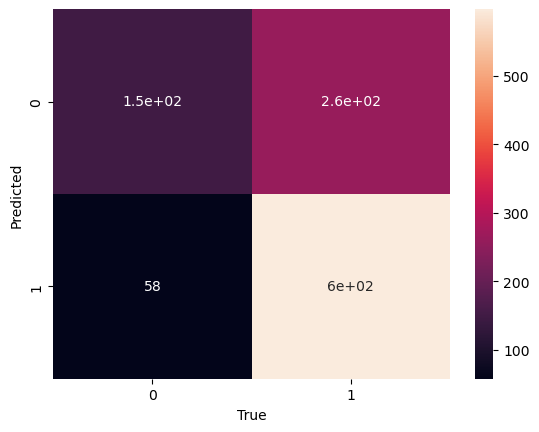

In [19]:
# Create the confusion matrix as a figure, we will later store it as a PNG image file
df_cm = pd.DataFrame(results)
cm = sns.heatmap(df_cm, annot=True)
cm.set_xlabel("True")
cm.set_ylabel("Predicted")
fig = cm.get_figure()

Once we have our model trained, we save it to Hopsworks together with the confusion matrix image.
We define the schema of the model (train and test data schema) together with the metrics we want to analyze (in our case it is the accuracy of the model predictions).

In [20]:
# We will now upload our model to the Hopsworks Model Registry. First get an object for the model registry.
mr = project.get_model_registry()

# The contents of the 'wine_model' directory will be saved to the model registry. Create the dir, first.
model_dir="wine_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
joblib.dump(model, model_dir + "/wine_model.pkl")
fig.savefig(model_dir + "/confusion_matrix.png")    

# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
wine_model = mr.python.create_model(
    name="wine_model", 
    metrics={"accuracy" : metrics['accuracy'], },
    model_schema=model_schema,
    description="Wine Predictor"
)

# Upload the model to the model registry, including all files in 'model_dir'
wine_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/14637 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/21144 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/487 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/193685/models/wine_model/3


Model(name: 'wine_model', version: 3)